In [35]:
import pyedflib
import numpy as np
import pandas as pd

In [36]:
import importlib

In [37]:
import scipy.signal as signal

from scipy.signal import hilbert

In [38]:
import arrow

In [39]:
from datetime import datetime as dt
from datetime import timedelta as td

In [40]:
from bs4 import BeautifulSoup

In [41]:
import matplotlib.pyplot as plt

In [169]:
import taa_calc
importlib.reload(taa_calc)
from taa_calc import (
    get_edf_signal_indices,
    read_edf_signals,
    read_edf_signals_file,
    get_edf_frequencies,
    resample_signals,
    preprocess,
    fund_freq,
    avg_resp_period,
    calc_windows,
    calc_taa,
    read_sleep_stages,
    read_resp_events,
    chart_taa,
    compute_perc_taa,
    read_files,
)

## Test with 300004

In [173]:
edf_id = "300004"
edf_id = "300013"
edf_id = "300066" # freq 32 but seems incorrect
# edf_id = "300132"

In [174]:
f = pyedflib.EdfReader(f'local-data/chat/polysomnography/edfs/baseline/chat-baseline-{edf_id}.edf')

In [175]:
with open(f'./local-data/chat/polysomnography/annotations-events-nsrr/baseline//chat-baseline-{edf_id}-nsrr.xml') as fp:
    annot = BeautifulSoup(fp)

In [176]:
f.samplefrequency(51)

0.0

In [177]:
f.getFileDuration()

35419

In [178]:
f.getStartdatetime()

datetime.datetime(1985, 1, 1, 20, 15, 33)

In [179]:
# The date information is nonsense, but the time is correct
start_dt = arrow.get(f.getStartdatetime())
start_dt

<Arrow [1985-01-01T20:15:33+00:00]>

In [180]:
start_dt.shift(seconds=37545)

<Arrow [1985-01-02T06:41:18+00:00]>

In [181]:
start_dt.time()

datetime.time(20, 15, 33)

In [182]:
# Uncomment to see the signal details
#f.getSignalHeaders()

In [183]:
# This is how you cleanup the f object
#f._close()
#del f

In [184]:
n = f.signals_in_file
n

38

In [185]:
annot_duration = int(float(annot.scoredevents.scoredevent.duration.text))
annot_duration

35419

In [186]:
sigs = read_edf_signals(f, ['ABD', 'Chest'])
f._close()
#sigs = read_edf_signals_file('local-data/chat-baseline-300004.edf', ['ABD', 'Chest', 'SAO2'])

In [187]:
freqs = get_edf_frequencies(f, ['ABD', 'Chest'])
assert freqs[0] == freqs[1]
freq = freqs[0]
freq

32

In [188]:
abd, chest = preprocess(sigs[0], sigs[1], orig_freq=freq)

In [190]:
avg_resp_period(abd, chest)

4.0

In [191]:
%%time
taa, taa_valid, taa_freq = calc_taa(abd, chest)

avg resp period 4.0 win 12.0 step size 1.0
CPU times: user 19.9 s, sys: 267 ms, total: 20.1 s
Wall time: 20.1 s


In [192]:
print(len(taa), taa_freq, np.sum(taa_valid != 0))

35408 1.0 1957


In [193]:
# Noisy abdomen signals
print(np.sum(taa_valid & 1 != 0))

1392


In [194]:
# Noisy chest signals
print(np.sum(taa_valid & 2 != 0))

812


In [200]:
# abdomen or chest noisy signal
print(np.sum((taa_valid & 3) != 0))

1923


In [201]:
# abdomen frequency out of range
print(np.sum(taa_valid & 4 != 0))

147


In [202]:
# chest frequency out of range
print(np.sum(taa_valid & 8 != 0))

48


In [203]:
# abdomen or chest frequency out of range
print(np.sum((taa_valid & 12) != 0))

191


In [204]:
# disparity between chest and abdominal frequencies
print(np.sum(taa_valid & 16 != 0))

191


In [205]:
stages = read_sleep_stages(annot_duration, annot.scoredevents.find_all('scoredevent'))

In [206]:
resp_events = read_resp_events(annot_duration, annot.scoredevents.find_all('scoredevent'))

In [207]:
len(taa), len(stages), len(resp_events)

(35408, 35419, 35419)

In [213]:
np.repeat(np.array([1, 2, 3]), 8)

array([1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3])

In [216]:
exp_stages = np.repeat(stages, 64)
exp_events = np.repeat(resp_events, 64)
len(exp_stages), len(exp_events)

(2266816, 2266816)

In [218]:
sleep_stages = (stages != 0)

In [220]:
np.sum(sleep_stages)

22740

In [ ]:
exp_stages

In [217]:
len(abd), len(chest)

(2266816, 2266816)

In [ ]:
def filter_arrays(arrays_to_filter, filters):
    """
    Filter a list of arrays by a list of filters.
    
    All arrays and filters should be the same length.
    
    This will apply each filter, in order, to each array
    and to each later filter
    """

In [165]:
np.bincount(resp_events)

array([27631,   643,  1051,   229,  8728,   340,    28])

In [166]:
sigs.shape

(2, 7730000)

In [25]:
# https://stackoverflow.com/questions/27545171/identifying-phase-shift-between-signals
print('''
x1 = sin( 0.1*arange(1024) )
x2 = sin( 0.1*arange(1024) + 0.456)
x1h = hilbert(x1)
x2h = hilbert(x2)
c = inner( x1h, conj(x2h) ) / sqrt( inner(x1h,conj(x1h)) * inner(x2h,conj(x2h)) )
phase_diff = angle(c)
''')


x1 = sin( 0.1*arange(1024) )
x2 = sin( 0.1*arange(1024) + 0.456)
x1h = hilbert(x1)
x2h = hilbert(x2)
c = inner( x1h, conj(x2h) ) / sqrt( inner(x1h,conj(x1h)) * inner(x2h,conj(x2h)) )
phase_diff = angle(c)



### Phase angle: Method 1 - looks OK

Issues:

* Verify center-windowing
* The TAA is calculated once for each window, we could also calculate for every second
* Math from stack overflow - need to verify

### Phase angle: Method 2 - not correct yet

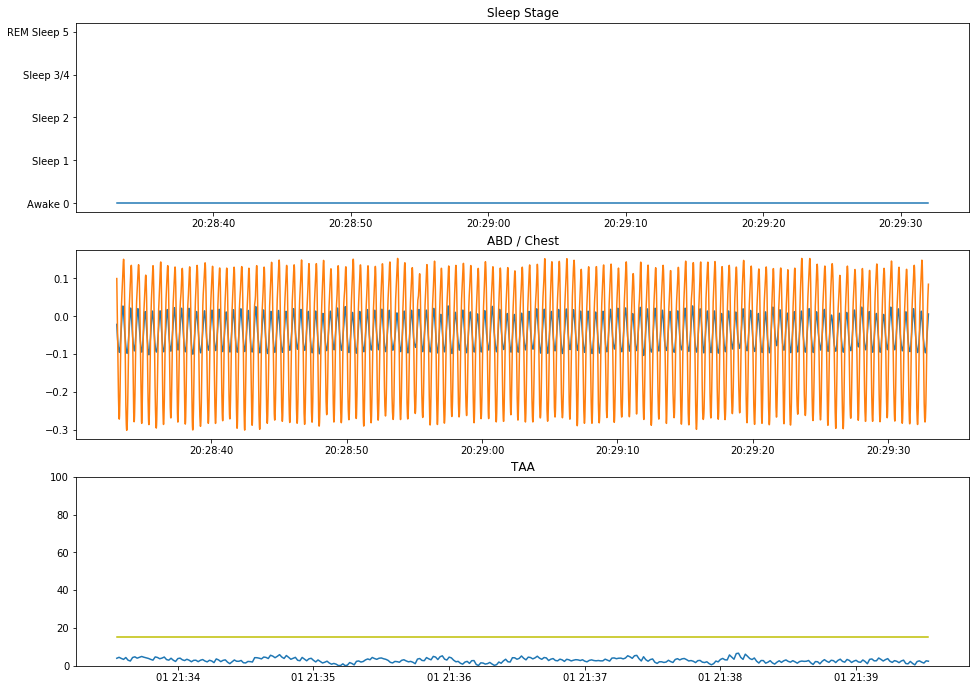

In [136]:
#chart_taa(start_time=11_530, window_len=60)
# 13_560 looks weird. Jumps too high too early
# 14_600 looks like TAA is ahead of the breathing problem
# 14_900 looks TAA delayed again
chart_taa(start_time=780, window_len=60,
         abd=abd, chest=chest, taa=taa, taa_freq=taa_freq,
         taa_valid=taa_valid, stages=stages, start_dt=start_dt)

## TODO

* Discard times when awake 
* Calculate % of time over 30% out of sync
* Figure out the breathing rate
* Discard breathing rate out of range

In [35]:
# Minutes in each sleep stage
np.bincount(stages)/60

array([163.25,  75.5 , 140.  , 145.  ,   0.  , 102.  ])

In [36]:
# Study length in hours
len(stages)/60/60

10.429166666666667

In [37]:
# hours awake
sum(stages == 0)/60/60

2.720833333333333

In [38]:
sleep_minutes = sum(stages != 0)/60
sleep_minutes

462.5

In [39]:
# Filter taa by time asleep
asleep_taa = taa[stages != 0]
len(asleep_taa)

27750

In [62]:
# Percent of time sleeping with taa > 30%
sum(asleep_taa > 0.3) / len(asleep_taa)

0.2570810810810811

In [58]:
# Minutes in each respiratory event
events = [
    'Normal',
    'Hypopnea',
    'Obstructive apnea',
    'Central apnea',
    'SpO2 desaturation',
    'SpO2 artifact',
    'Unsure',
    'Other',
]
list(zip(np.round(np.bincount(resp_events)/60,0), events))

[(585.0, 'Normal'),
 (6.0, 'Hypopnea'),
 (2.0, 'Obstructive apnea'),
 (0.0, 'Central apnea'),
 (29.0, 'SpO2 desaturation'),
 (3.0, 'SpO2 artifact'),
 (0.0, 'Unsure')]

In [60]:
# Filter taa by time asleep
asleep_taa = taa[stages != 0]
asleep_events = resp_events[stages != 0]
result = asleep_taa[(asleep_events != 1) & (asleep_events != 2) & (asleep_events != 3)]
len(result)

27247

In [63]:
# Percent of time sleeping with taa > 30%
sum(result > 0.3) / len(result)

0.25213785003853634

In [266]:
f._close()

200

In [27]:
f = pyedflib.EdfReader('./local-data/chat/polysomnography/edfs/baseline/chat-baseline-300013.edf')


In [28]:
signal_labels = ['ABD','Chest']
edf_indices = get_edf_signal_indices(f, signal_labels)
orig_freq = int(f.samplefrequency(edf_indices[0]))


In [29]:
edf_indices

[34, 33]

In [30]:
f.samplefrequency(23)

200.00000000000003

In [31]:
f.samplefrequency(24)

200.00000000000003

In [32]:
labels = f.getSignalLabels()

In [273]:
list(zip(labels, [f.samplefrequency(i) for i in range(len(labels))]))

[('Event', 200.00000000000003),
 ('C3', 200.00000000000003),
 ('C4', 200.00000000000003),
 ('O1', 200.00000000000003),
 ('O2', 200.00000000000003),
 ('M1', 200.00000000000003),
 ('M2', 200.00000000000003),
 ('Cchin', 200.00000000000003),
 ('F3', 200.00000000000003),
 ('F4', 200.00000000000003),
 ('F7', 200.00000000000003),
 ('F8', 200.00000000000003),
 ('Fz', 200.00000000000003),
 ('Fp1', 200.00000000000003),
 ('Fp2', 200.00000000000003),
 ('Fpz', 200.00000000000003),
 ('P3', 200.00000000000003),
 ('P4', 200.00000000000003),
 ('ECG3', 200.00000000000003),
 ('T3', 200.00000000000003),
 ('T4', 200.00000000000003),
 ('T5', 200.00000000000003),
 ('T6', 200.00000000000003),
 ('E1', 200.00000000000003),
 ('E2', 200.00000000000003),
 ('Lchin', 200.00000000000003),
 ('Rchin', 200.00000000000003),
 ('ECG1', 200.00000000000003),
 ('ECG2', 200.00000000000003),
 ('Lleg1', 200.00000000000003),
 ('Lleg2', 200.00000000000003),
 ('Rleg1', 200.00000000000003),
 ('Rleg2', 200.00000000000003),
 ('Chest',

In [226]:
%%time
results = compute_perc_taa()
results

baseline/chat-baseline-300004 sample frequency is 200.


NameError: name 'nonevent_sleep' is not defined

In [232]:
compute_perc_taa('baseline/chat-baseline-300001')

baseline/chat-baseline-300001 sample frequency is 128.


('baseline/chat-baseline-300001',
 'success',
 32258,
 3608,
 28650,
 930,
 13020,
 8610,
 6090,
 28411,
 28411,
 0.01323431065432403,
 0.042905916722396256,
 0.02228010277709338,
 0.01323431065432403,
 0.009010594488050402,
 0.006687550596599909,
 0.006159586075815705)

In [80]:
def read_files(files):
    dtypes = np.dtype([
        ('filename', np.object),
        ('comment', np.object),
        ('orig_freq', np.int64),
        ('duration_sec', np.int64),
        ('awake_seconds', np.int64),
        ('sleep_seconds', np.int64),
        ('stage_1_seconds', np.int64),
        ('stage_2_seconds', np.int64),
        ('stage_3_seconds', np.int64),
        ('stage_5_seconds', np.int64),
        ('hyp_apnea_seconds', np.int64),
        ('asleep_non_event_seconds', np.int64),
        ('time_in_async_30p', np.float64),
        ('time_in_async_25p', np.float64),
        ('time_in_async_50p', np.float64),
        ('time_in_async_75p', np.float64),
    ])
    df = np.empty(len(files), dtypes)
    for i, filename in enumerate(files):
        print(f"{i:3} processing {filename}")
        df[i] = compute_perc_taa(filename)
    results_df = pd.DataFrame(df, index=files)
    results_df = results_df.drop(columns='filename')
    results_df.index.name = 'filename'
    return results_df

In [47]:
_ = '''
'''
baseline_files = '''
chat-baseline-300001.edf
chat-baseline-300002.edf
chat-baseline-300004.edf
chat-baseline-300007.edf
chat-baseline-300008.edf
chat-baseline-300013.edf
chat-baseline-300014.edf
chat-baseline-300015.edf
chat-baseline-300019.edf
chat-baseline-300021.edf
chat-baseline-300024.edf
chat-baseline-300025.edf
chat-baseline-300026.edf
chat-baseline-300031.edf
chat-baseline-300033.edf
chat-baseline-300036.edf
chat-baseline-300037.edf
chat-baseline-300038.edf
chat-baseline-300039.edf
chat-baseline-300041.edf
chat-baseline-300042.edf
chat-baseline-300043.edf
chat-baseline-300051.edf
chat-baseline-300052.edf
chat-baseline-300055.edf
chat-baseline-300058.edf
chat-baseline-300062.edf
chat-baseline-300063.edf
chat-baseline-300066.edf
chat-baseline-300069.edf
chat-baseline-300071.edf
chat-baseline-300072.edf
chat-baseline-300073.edf
chat-baseline-300077.edf
chat-baseline-300078.edf
chat-baseline-300081.edf
chat-baseline-300098.edf
chat-baseline-300102.edf
chat-baseline-300108.edf
chat-baseline-300111.edf
chat-baseline-300117.edf
chat-baseline-300122.edf
chat-baseline-300129.edf
chat-baseline-300130.edf
chat-baseline-300132.edf
chat-baseline-300133.edf
chat-baseline-300134.edf
chat-baseline-300139.edf
chat-baseline-300141.edf
chat-baseline-300144.edf
chat-baseline-300150.edf
chat-baseline-300153.edf
chat-baseline-300157.edf
chat-baseline-300158.edf
chat-baseline-300160.edf
chat-baseline-300166.edf
chat-baseline-300167.edf
'''

In [45]:
import taa_calc
importlib.reload(taa_calc)
from taa_calc import (
    get_edf_signal_indices,
    read_edf_signals,
    read_edf_signals_file,
    resample_signals,
    preprocess,
    fund_freq,
    avg_resp_period,
    calc_windows,
    calc_taa,
    read_sleep_stages,
    read_resp_events,
    chart_taa,
    compute_perc_taa,
    read_files,
)

In [49]:
from itertools import islice

In [43]:
def get_freq(filename='baseline/chat-baseline-300004', taa_cutoff=0.3,
                    fileroot='local-data/chat/polysomnography',):
    EDF_DIR = 'edfs'
    
    edf_file = f'{fileroot}/{EDF_DIR}/{filename}.edf'
    print(f"Opening {edf_file}")
    
    f = pyedflib.EdfReader(edf_file)
    signal_labels = ['ABD','Chest']
    edf_indices = get_edf_signal_indices(f, signal_labels)
    orig_freq = int(f.samplefrequency(edf_indices[0]))
    f._close()
    return orig_freq


In [44]:
files = [f'baseline/{fn.split(".edf")[0]}' for fn in baseline_files.strip().split('\n')]
for file in files:
    print(get_freq(file))

Opening local-data/chat/polysomnography/edfs/baseline/chat-baseline-300001.edf
128
Opening local-data/chat/polysomnography/edfs/baseline/chat-baseline-300002.edf
200
Opening local-data/chat/polysomnography/edfs/baseline/chat-baseline-300004.edf
200
Opening local-data/chat/polysomnography/edfs/baseline/chat-baseline-300007.edf
32
Opening local-data/chat/polysomnography/edfs/baseline/chat-baseline-300008.edf
32
Opening local-data/chat/polysomnography/edfs/baseline/chat-baseline-300013.edf
200
Opening local-data/chat/polysomnography/edfs/baseline/chat-baseline-300014.edf
200
Opening local-data/chat/polysomnography/edfs/baseline/chat-baseline-300015.edf
32
Opening local-data/chat/polysomnography/edfs/baseline/chat-baseline-300019.edf
200
Opening local-data/chat/polysomnography/edfs/baseline/chat-baseline-300021.edf
512
Opening local-data/chat/polysomnography/edfs/baseline/chat-baseline-300024.edf
256
Opening local-data/chat/polysomnography/edfs/baseline/chat-baseline-300025.edf
32
Opening 

In [50]:
files = [f'baseline/{fn.split(".edf")[0]}' for fn in baseline_files.strip().split('\n')]
test_df = read_files(list(islice(files, 2)))
test_df

  0 processing baseline/chat-baseline-300001
baseline/chat-baseline-300001 sample frequency is 128.


/Users/jbranam/files/study/iums/d590_dsip/aisdb/aisdb/taa_calc.py:361: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 361 of the file /Users/jbranam/files/study/iums/d590_dsip/aisdb/aisdb/taa_calc.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.



avg resp period 4.0 win 12.0 step size 1.0


AssertionError: 

In [ ]:
results_df.head(4)

In [46]:
files = [f'baseline/{fn.split(".edf")[0]}' for fn in baseline_files.strip().split('\n')]
#results_df = read_files(list(islice(files,10)))
results_df = read_files(files)

  0 processing baseline/chat-baseline-300001
baseline/chat-baseline-300001 sample frequency is 128.
  1 processing baseline/chat-baseline-300002
baseline/chat-baseline-300002 sample frequency is 200.
  2 processing baseline/chat-baseline-300004
baseline/chat-baseline-300004 sample frequency is 200.
  3 processing baseline/chat-baseline-300007
baseline/chat-baseline-300007 sample frequency is 32.
  4 processing baseline/chat-baseline-300008
baseline/chat-baseline-300008 sample frequency is 32.
  5 processing baseline/chat-baseline-300013
baseline/chat-baseline-300013 sample frequency is 200.
  6 processing baseline/chat-baseline-300014
baseline/chat-baseline-300014 sample frequency is 200.
  7 processing baseline/chat-baseline-300015
baseline/chat-baseline-300015 sample frequency is 32.
  8 processing baseline/chat-baseline-300019
baseline/chat-baseline-300019 sample frequency is 200.
  9 processing baseline/chat-baseline-300021
baseline/chat-baseline-300021 sample frequency is 512.
 10

In [50]:
# results_df = results_df.rename(columns={'time_in_async':'time_in_async_30p'})

In [51]:
# results_df['hyp_apnea_seconds'] = results_df['sleep_seconds'] - results_df['asleep_non_event_seconds']

In [67]:
results_df.head()

,comment,duration_sec,awake_seconds,sleep_seconds,stage_1_seconds,stage_2_seconds,stage_3_seconds,stage_5_seconds,hyp_apnea_seconds,asleep_non_event_seconds,time_in_async_30p,time_in_async_25p,time_in_async_50p,time_in_async_75p
filename,,,,,,,,,,,,,,
baseline/chat-baseline-300001,success,32258,3608,28650,930,13020,8610,6090,239,28411,0.0132,0.0223,0.0056,0.0022
baseline/chat-baseline-300002,success,45349,16219,29130,2460,16440,5490,4740,403,28727,0.0498,0.0825,0.0179,0.0076
baseline/chat-baseline-300004,success,37545,9795,27750,4530,8400,8700,6120,503,27247,0.2521,0.2821,0.1810,0.1196
baseline/chat-baseline-300007,success,35792,8042,27750,3540,13650,5370,5190,165,27585,0.0328,0.0440,0.0125,0.0051
baseline/chat-baseline-300008,success,32477,4517,27960,3840,8910,9900,5310,248,27712,0.3740,0.4175,0.1827,0.0795


In [65]:
results_df.head(1)

,comment,duration_sec,awake_seconds,sleep_seconds,stage_1_seconds,stage_2_seconds,stage_3_seconds,stage_5_seconds,hyp_apnea_seconds,asleep_non_event_seconds,time_in_async_30p,time_in_async_25p,time_in_async_50p,time_in_async_75p
filename,,,,,,,,,,,,,,
baseline/chat-baseline-300001,success,32258,3608,28650,930,13020,8610,6090,239,28411,0.0132,0.0223,0.0056,0.0022


In [79]:
date_str = '2019_10_30'
#results_df.to_csv(f'exports/results_{date_str}.csv', header=True)
#results_df.describe().to_csv(f'exports/results_stats_{date_str}.csv', header=True)

In [94]:
np.empty((1,3))

array([[1.04e-322, 1.04e-322, 1.04e-322]])

In [78]:
results_df.dtypes

comment                      object
duration_sec                  int64
awake_seconds                 int64
sleep_seconds                 int64
stage_1_seconds               int64
stage_2_seconds               int64
stage_3_seconds               int64
stage_5_seconds               int64
hyp_apnea_seconds             int64
asleep_non_event_seconds      int64
time_in_async_30p           float64
time_in_async_25p           float64
time_in_async_50p           float64
time_in_async_75p           float64
dtype: object

In [83]:
results_df

,filename,duration_sec,awake_seconds,sleep_seconds,stage_1_seconds,stage_2_seconds,stage_3_seconds,stage_5_seconds,hyp_apnea_seconds,asleep_non_event_seconds,time_in_async,time_in_async_20p,time_in_async_25p,time_in_async_30p,time_in_async_25p,time_in_async_40p,time_in_async_25p
baseline/chat-baseline-300004,baseline/chat-baseline-300004,37545,9795,27750,4530,8400,8700,6120,27247,27247,0.25213785003853634,0.32150328476529527,0.2820861012221529,0.25213785003853634,0.2293830513451022,0.210004771167468,0.19492054171101406
baseline/chat-baseline-300013,baseline/chat-baseline-300013,37446,7326,30120,1620,12450,12060,3990,29866,29866,0.08755775798566932,0.19011585080024107,0.1351704279113373,0.08755775798566932,0.05240072323042925,0.025915757048148396,0.013962365231366772


In [75]:
results_df_orig

,filename,duration_sec,awake_seconds,sleep_seconds,stage_1_seconds,stage_2_seconds,stage_3_seconds,stage_5_seconds,hyp_apnea_seconds,asleep_non_event_seconds,time_in_async,time_in_async_20p,time_in_async_25p,time_in_async_30p,time_in_async_25p,time_in_async_40p,time_in_async_25p
baseline/chat-baseline-300004,baseline/chat-baseline-300004,37545,9795,27750,4530,8400,8700,6120,27247,27247,0.25213785003853634,0.32150328476529527,0.2820861012221529,0.25213785003853634,0.2293830513451022,0.210004771167468,0.19492054171101406
baseline/chat-baseline-300013,baseline/chat-baseline-300013,37446,7326,30120,1620,12450,12060,3990,29866,29866,0.08755775798566932,0.19011585080024107,0.1351704279113373,0.08755775798566932,0.05240072323042925,0.025915757048148396,0.013962365231366772


In [119]:
import librosa
abd_stft = librosa.stft(sigs[0], n_fft=512, win_length=512)

In [120]:
abd_stft[:5,1000:1005]

array([[ 2.2297444e+03+0.0000000e+00j,  2.2297444e+03+0.0000000e+00j,
         2.2297444e+03+0.0000000e+00j,  2.2297444e+03+0.0000000e+00j,
         2.2297444e+03+0.0000000e+00j],
       [-1.1148722e+03+1.8103927e-06j, -1.1148722e+03+4.2418683e-06j,
        -1.1148722e+03-7.2597636e-06j, -1.1148722e+03+4.8980955e-06j,
        -1.1148722e+03+8.4729157e-07j],
       [ 4.3148368e-05-1.1607954e-05j, -3.5863650e-05-2.5851639e-05j,
         2.7103206e-06+4.4517958e-05j,  3.2103282e-05-3.1169391e-05j,
        -4.3877033e-05-5.2358600e-06j],
       [-4.5741639e-05+1.1831351e-05j,  3.9784747e-05+2.8701152e-05j,
        -4.5752799e-06-4.8121641e-05j, -3.4906956e-05+3.2143424e-05j,
         4.8744354e-05+5.8005276e-06j],
       [ 3.3357603e-05-1.4721012e-05j, -1.3998673e-06+1.7351787e-05j,
        -2.4638781e-05+1.3255505e-05j,  1.0010871e-05-3.3202803e-05j,
         1.3037528e-05+5.3128415e-06j]], dtype=complex64)

In [132]:
np.argsort(np.abs(abd_stft[:,3000:3005]), axis=0)[-10:]

array([[207,   6, 205, 205, 147],
       [  6, 205, 202, 147, 205],
       [205, 202,   7,   7,   7],
       [  7,   7,   6, 256,   6],
       [  4,   4,   4,   4,   4],
       [  5,   5,   5,   5,   5],
       [  3,   3,   3,   3,   3],
       [  2,   1,   2,   2,   2],
       [  1,   2,   1,   1,   1],
       [  0,   0,   0,   0,   0]])

In [131]:
fft_freq = librosa.fft_frequencies(sr=200, n_fft=512)
print(f"1 {fft_freq[1]}")
print(f"38 {fft_freq[38]}")
print(f"197 {fft_freq[197]}")
print(f"159 {fft_freq[159]}")
print(f"156 {fft_freq[156]}")

1 0.390625
38 14.84375
197 76.953125
159 62.109375
156 60.9375


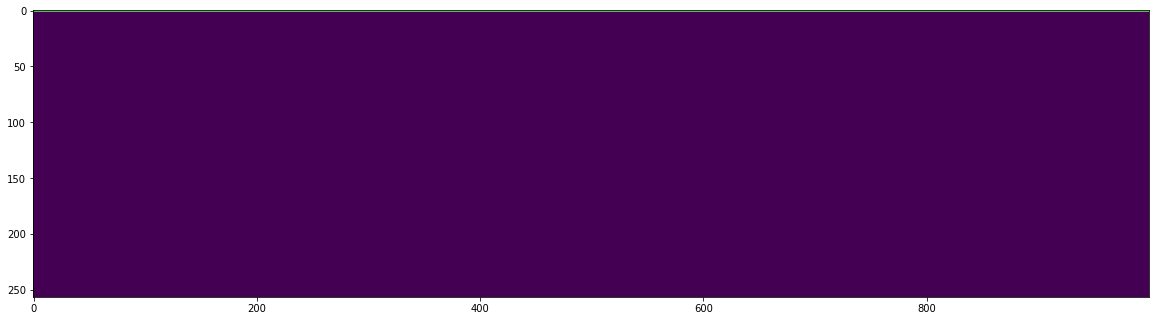

In [122]:
plt.figure(figsize=(20,10))
plt.imshow(np.power(np.abs(abd_stft[:,1000:2000]),0.5))

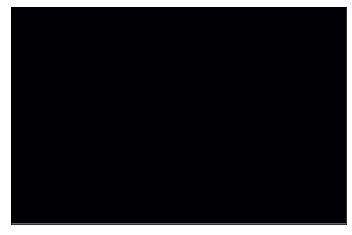

In [142]:
import librosa.display
librosa.display.specshow(np.abs(abd_stft[:,1000:1010]),sr=200)

In [234]:
abd, chest = preprocess(sigs)

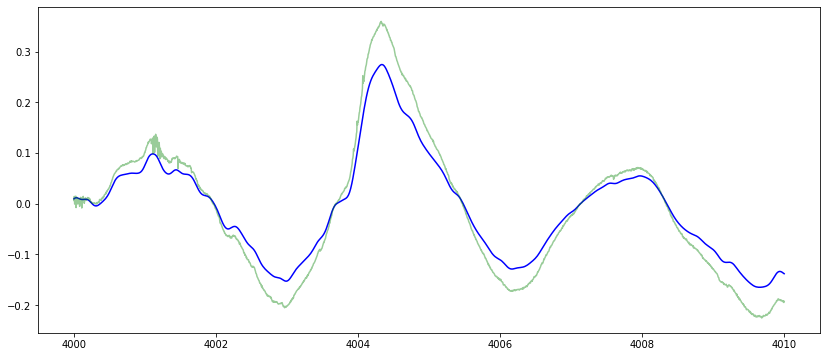

In [44]:
plt.figure(figsize=(14,6))
# plt.plot(sigs[0,rng], 'y')
start = 4_000
end = start + 10
#x = np.arange(start, end)
#plt.ylim(-0.2, 0.2)
plt.plot(np.linspace(start, end, (end-start)*64), abd[start*64:end*64], 'b')
plt.plot(np.linspace(start, end, (end-start)*200), sigs[0,start*200:end*200], 'g', alpha=0.4)

#plt.plot(np.linspace(start, end, (end-start)*64), chest[start*64:end*64], 'r')
#plt.plot(np.linspace(start, end, (end-start)*200), sigs[1,start*200:end*200], 'y', alpha=0.4)

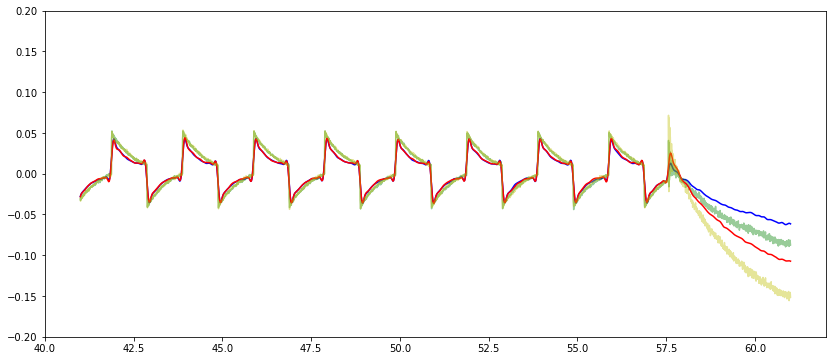

In [267]:
plt.figure(figsize=(14,6))
# plt.plot(sigs[0,rng], 'y')
start = 41
end = start + 20
#x = np.arange(start, end)
plt.ylim(-0.2, 0.2)
plt.plot(np.linspace(start, end, (end-start)*64), abd[start*64:end*64], 'b')
plt.plot(np.linspace(start, end, (end-start)*200), sigs[0,start*200:end*200], 'g', alpha=0.4)

plt.plot(np.linspace(start, end, (end-start)*64), chest[start*64:end*64], 'r')
plt.plot(np.linspace(start, end, (end-start)*200), sigs[1,start*200:end*200], 'y', alpha=0.4)

In [232]:
# resample to 64Hz
abd_64 = signal.resample(sigs[0], int(len(sigs[0])*64/200 ))
chest_64 = signal.resample(sigs[0], int(len(sigs[1])*64/200 ))

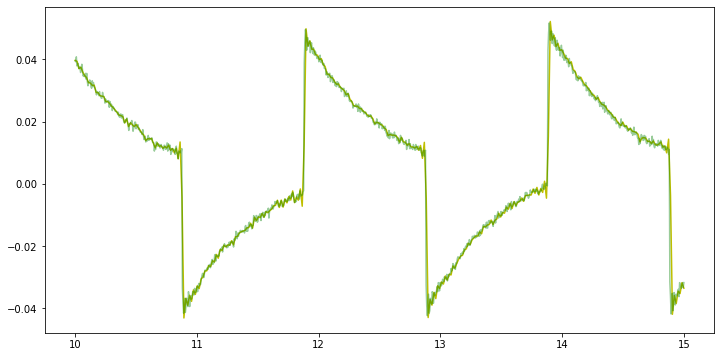

In [231]:
plt.figure(figsize=(12,6))
# plt.plot(sigs[0,rng], 'y')
start, end = 10, 15
#x = np.arange(start, end)
plt.plot(np.linspace(start, end, (end-start)*64), abd_64[start*64:end*64], 'y')
plt.plot(np.linspace(start, end, (end-start)*200), sigs[0,start*200:end*200], 'g', alpha=0.4)

In [220]:
import scipy.signal as signal
bands =   (0, 0.05, 0.1, 5, 10, 32)
desired = (0, 0,    1,   1, 0, 0)
# b_firwin = signal.firwin(numtaps=73, cutoff=5, fs=200, pass_zero=False)
b_firwin = signal.firwin2(73, bands, desired, fs=64)
b_firls = signal.firls(73, bands, desired, fs=64)
#signal.firwin?

In [221]:
#freq, response = signal.freqz(b_firwin)
y = signal.filtfilt(b_firwin, 1, abd_64)
y2 = signal.filtfilt(b_firls, 1, abd_64)

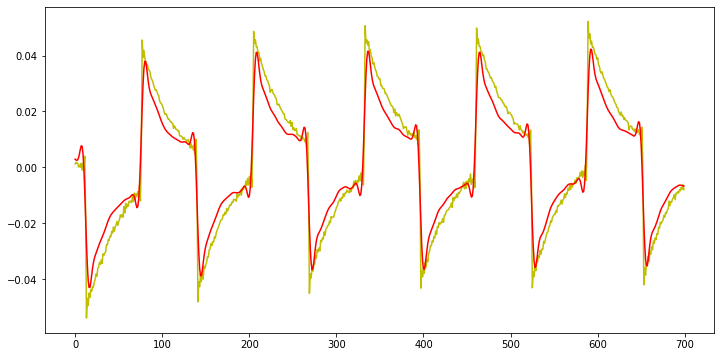

In [227]:
rng = np.arange(300,1000)
plt.figure(figsize=(12,6))
# plt.plot(sigs[0,rng], 'y')
plt.plot(abd_64[rng], 'y')
plt.plot(y[rng], 'r')
#plt.plot(y2[rng], 'g')

In [21]:
signal_labels = f.getSignalLabels()
list(zip(signal_labels, range(len(signal_labels))))

[('Event', 0),
 ('C3', 1),
 ('C4', 2),
 ('O1', 3),
 ('O2', 4),
 ('M1', 5),
 ('M2', 6),
 ('Cchin', 7),
 ('F3', 8),
 ('F4', 9),
 ('F7', 10),
 ('F8', 11),
 ('Fz', 12),
 ('Fp1', 13),
 ('Fp2', 14),
 ('Fpz', 15),
 ('P3', 16),
 ('P4', 17),
 ('ECG3', 18),
 ('T3', 19),
 ('T4', 20),
 ('T5', 21),
 ('T6', 22),
 ('E1', 23),
 ('E2', 24),
 ('Lchin', 25),
 ('Rchin', 26),
 ('ECG2', 27),
 ('ECG1', 28),
 ('Lleg1', 29),
 ('Lleg2', 30),
 ('Rleg1', 31),
 ('Rleg2', 32),
 ('Chest', 33),
 ('ABD', 34),
 ('Airflow', 35),
 ('Snore', 36),
 ('CannulaFlow', 37),
 ('SUM', 38),
 ('Position', 39),
 ('DC2', 40),
 ('DC3', 41),
 ('DC4', 42),
 ('CPress', 43),
 ('CFlow', 44),
 ('Cap', 45),
 ('EtCO2', 46),
 ('EXTSAT', 47),
 ('Pleth', 48),
 ('SAO2', 49),
 ('PR', 50),
 ('DHR', 51)]

In [22]:
f.getNSamples()

array([7509000, 7509000, 7509000, 7509000, 7509000, 7509000, 7509000,
       7509000, 7509000, 7509000, 7509000, 7509000, 7509000, 7509000,
       7509000, 7509000, 7509000, 7509000, 7509000, 7509000, 7509000,
       7509000, 7509000, 7509000, 7509000, 7509000, 7509000, 7509000,
       7509000, 7509000, 7509000, 7509000, 7509000, 7509000, 7509000,
       7509000, 7509000, 7509000, 7509000, 7509000, 7509000, 7509000,
       7509000, 7509000, 7509000, 7509000, 7509000, 7509000, 7509000,
       7509000, 7509000, 7509000])

## Learn about Welch's power spectral density estimation

In [7]:
fs = 10e3
N = 1e5
amp = 2*np.sqrt(2)
freq = 1234.0
noise_power = 0.001 * fs / 2
time = np.arange(N) / fs
x = amp*np.sin(2*np.pi*freq*time)
x += np.random.normal(scale=np.sqrt(noise_power), size=time.shape)

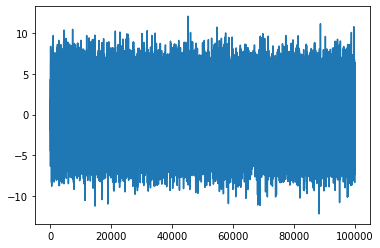

In [8]:
plt.plot(x)

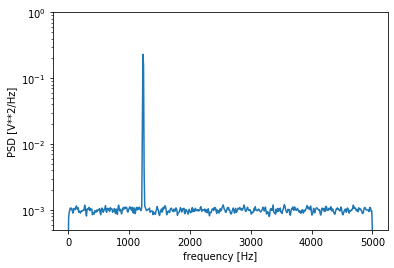

In [9]:
f, Pxx_den = signal.welch(x, fs, nperseg=1024)
plt.semilogy(f, Pxx_den)
plt.ylim([0.5e-3, 1])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

In [10]:
f.shape

(513,)

In [11]:
Pxx_den.shape

(513,)

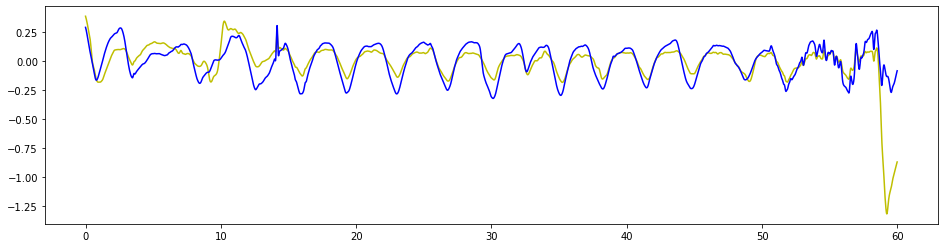

In [116]:
s = 3_624*64
rng = np.arange(s,s+60*64)
plt.figure(figsize=(16,4))
#plt.plot(rng, abd[rng], 'y')
plt.plot(np.arange(60*64)/64,abd[rng], 'y')
plt.plot(np.arange(60*64)/64,chest[rng], 'b')

In [304]:
1/0.3

3.3333333333333335

In [303]:
18/60

0.3

0.3125


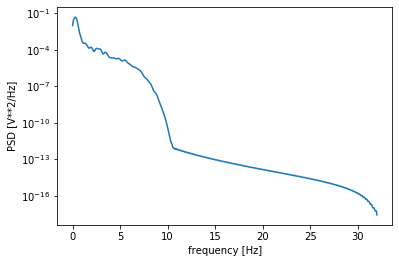

In [305]:
f, Pxx_den = signal.welch(chest[rng], 64, nfft=1024)
print(f[np.argmax(Pxx_den)])
plt.semilogy(f, Pxx_den)
#plt.ylim([0.5e-5, 1])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

## number 1

In [308]:
f[2:10]

array([0.125 , 0.1875, 0.25  , 0.3125, 0.375 , 0.4375, 0.5   , 0.5625])

In [306]:
np.sum(Pxx_den)

0.31680387786647557

In [309]:
np.sum(Pxx_den[2:10])

0.26294395076817106

In [311]:
np.sum(Pxx_den[2:10]) / np.sum(Pxx_den)

0.8299896849084498

## number 2

In [312]:
print(f[np.argmax(Pxx_den)])

0.3125


# Test 3

In [313]:
f, Pxx_den = signal.welch(abd[rng], 64, nfft=1024)
print(f[np.argmax(Pxx_den)])

0.25


In [317]:
(0.3125 - 0.25) / 0.25

0.25

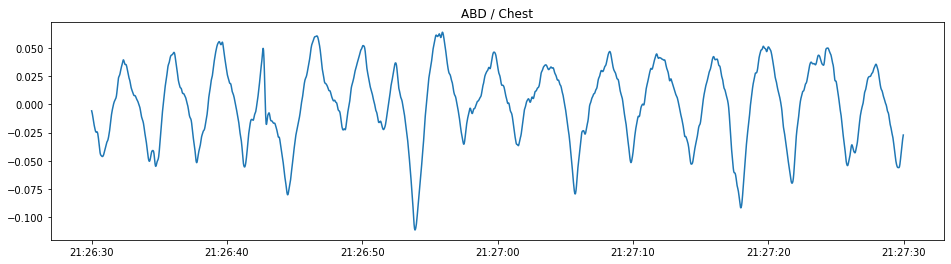

In [79]:
freq = 64
start_time = 5_600
window_len=60

plot_range = np.arange(start_time*freq, (start_time+window_len)*freq)

time_range = np.empty_like(plot_range, dtype='datetime64[ms]')
for i in range(len(plot_range)):
    time_range[i] = start_dt.naive + td(milliseconds=plot_range[i]*1/freq*1000)

plt.figure(figsize=(16,4))
plt.title('ABD / Chest')
plt.plot(time_range, abd[plot_range])
    

0.25


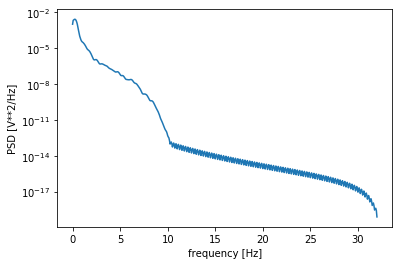

In [226]:
f, Pxx_den = signal.welch(abd[plot_range], 64, nfft=1024)
print(f[np.argmax(Pxx_den)])
plt.semilogy(f, Pxx_den)
#plt.ylim([0.5e-3, 1])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

In [234]:
np.logical_and(f >= 0.12, f <= 0.585)[2:10]

array([ True,  True,  True,  True,  True,  True,  True,  True])

In [227]:
f

array([ 0.    ,  0.0625,  0.125 ,  0.1875,  0.25  ,  0.3125,  0.375 ,
        0.4375,  0.5   ,  0.5625,  0.625 ,  0.6875,  0.75  ,  0.8125,
        0.875 ,  0.9375,  1.    ,  1.0625,  1.125 ,  1.1875,  1.25  ,
        1.3125,  1.375 ,  1.4375,  1.5   ,  1.5625,  1.625 ,  1.6875,
        1.75  ,  1.8125,  1.875 ,  1.9375,  2.    ,  2.0625,  2.125 ,
        2.1875,  2.25  ,  2.3125,  2.375 ,  2.4375,  2.5   ,  2.5625,
        2.625 ,  2.6875,  2.75  ,  2.8125,  2.875 ,  2.9375,  3.    ,
        3.0625,  3.125 ,  3.1875,  3.25  ,  3.3125,  3.375 ,  3.4375,
        3.5   ,  3.5625,  3.625 ,  3.6875,  3.75  ,  3.8125,  3.875 ,
        3.9375,  4.    ,  4.0625,  4.125 ,  4.1875,  4.25  ,  4.3125,
        4.375 ,  4.4375,  4.5   ,  4.5625,  4.625 ,  4.6875,  4.75  ,
        4.8125,  4.875 ,  4.9375,  5.    ,  5.0625,  5.125 ,  5.1875,
        5.25  ,  5.3125,  5.375 ,  5.4375,  5.5   ,  5.5625,  5.625 ,
        5.6875,  5.75  ,  5.8125,  5.875 ,  5.9375,  6.    ,  6.0625,
        6.125 ,  6.1

In [135]:
Pxx_den[:5]

array([0.00309576, 0.02228785, 0.01059706, 0.00301506, 0.00156199])

0.25


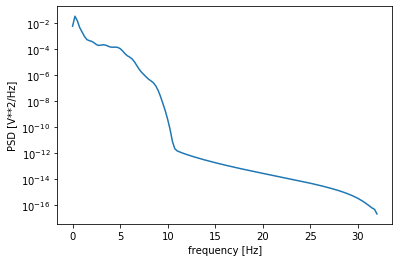

In [139]:
f, Pxx_den = signal.welch(chest, 64)
print(f[np.argmax(Pxx_den)])
plt.semilogy(f, Pxx_den)
#plt.ylim([0.5e-3, 1])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()